In [2]:
import numpy as np
import pandas as pd

def f(x1, x2):
    return (1.3356 * (1.5 * (1 - x1)) 
            + np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2))
            + np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))

def GetGrid(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = f(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../../results_f/virtual_samples_Matern_0.5.xlsx")

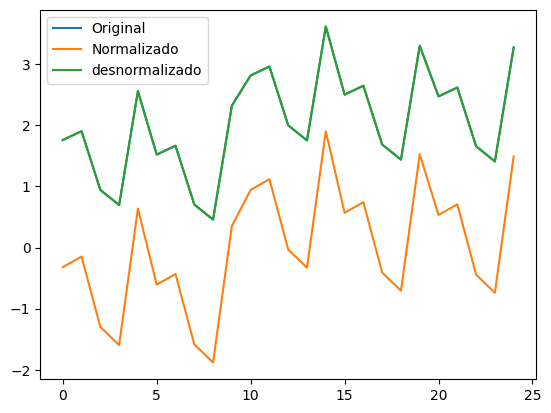

In [3]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:26:42.599191: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:26:42.603935: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:26:42.620508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753136802.681659    1984 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753136802.697848    1984 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753136802.775516    1984 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.2, 0.02],
            learning_rate=[0.1, 0.01])

Testando combinacao1: Hidden Size=[4, 2], regularizer=0.2, learning_rate=0.1


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_8,0.974913,0.745035,0.900199,0.948894,0.013303,0.151358,0.085005,0.043635,0.049687,0.115339,0.958831,0.117155,58.639535,112.999217
model_1_0_7,0.972053,0.721468,0.893708,0.957264,0.014819,0.165349,0.090533,0.036489,0.056673,0.121735,0.954139,0.123652,58.423647,112.783328
model_1_0_6,0.970847,0.718799,0.891731,0.956798,0.015459,0.166933,0.092217,0.036886,0.058013,0.124334,0.952159,0.126292,58.339127,112.698809
model_1_0_5,0.968846,0.714175,0.889426,0.956405,0.016520,0.169678,0.094181,0.037222,0.060528,0.128531,0.948875,0.130555,58.206354,112.566035
model_1_0_4,0.946470,0.697342,0.862660,0.907910,0.028386,0.179671,0.116978,0.078627,0.067148,0.168480,0.912155,0.171133,57.123752,111.483433
model_1_0_2,0.913260,0.661174,0.800122,0.909132,0.045995,0.201142,0.170244,0.077584,0.122294,0.214465,0.857658,0.217843,56.158429,110.518111
model_1_0_3,0.917509,0.657555,0.802486,0.905315,0.043742,0.203290,0.168231,0.080843,0.111955,0.209147,0.864630,0.212441,56.258873,110.618555
model_1_0_1,0.732540,0.554689,0.600546,0.712656,0.141826,0.264356,0.340231,0.245337,0.222752,0.376597,0.561092,0.382528,53.906315,108.265997
model_1_0_0,0.674745,0.544326,0.549806,0.642101,0.172473,0.270508,0.383449,0.305577,0.239662,0.415298,0.466247,0.421839,53.515032,107.874714


DataFrame salvo em ./content/results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_5,0.981075,0.734744,0.907415,0.957851,0.010035,0.157467,0.078858,0.027594,0.046325,0.100176,0.968944,0.101754,59.203288,113.562970
model_1_1_4,0.981424,0.733513,0.907505,0.959732,0.009851,0.158198,0.078782,0.026362,0.046316,0.099250,0.969516,0.100813,59.240462,113.600143
model_1_1_0,0.976881,0.732851,0.906916,0.980427,0.012259,0.158591,0.079284,0.012814,0.050909,0.110722,0.962061,0.112466,58.802914,113.162596
model_1_1_6,0.981265,0.732195,0.908700,0.956863,0.009935,0.158981,0.077764,0.028241,0.046405,0.099673,0.969255,0.101243,59.223435,113.583117
model_1_1_7,0.981426,0.731622,0.910682,0.955928,0.009849,0.159321,0.076075,0.028852,0.045806,0.099243,0.969520,0.100806,59.240723,113.600405
model_1_1_3,0.981439,0.731562,0.907035,0.961615,0.009843,0.159356,0.079182,0.025129,0.047195,0.099210,0.969540,0.100772,59.242077,113.601759
model_1_1_8,0.981324,0.731351,0.911250,0.954468,0.009903,0.159482,0.075592,0.029808,0.045488,0.099516,0.969352,0.101083,59.229743,113.589424
model_1_1_2,0.981301,0.731242,0.905769,0.961078,0.009915,0.159547,0.080260,0.025481,0.046754,0.099575,0.969315,0.101144,59.227357,113.587039
model_1_1_9,0.981130,0.731216,0.911352,0.953096,0.010006,0.159562,0.075505,0.030707,0.045397,0.100030,0.969034,0.101606,59.209124,113.568806
model_1_1_1,0.980431,0.729246,0.907560,0.981567,0.010377,0.160731,0.078735,0.012068,0.050907,0.101866,0.967887,0.103470,59.136385,113.496067


DataFrame salvo em ./content/results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_5,0.982815,0.733918,0.930528,0.961693,0.009112,0.157958,0.059172,0.024573,0.043418,0.095459,0.971800,0.096963,59.396228,113.755910
model_1_2_0,0.981651,0.732261,0.913144,0.964782,0.009730,0.158941,0.073979,0.022591,0.044976,0.098642,0.969888,0.100195,59.265050,113.624732
model_1_2_4,0.982765,0.731151,0.928880,0.962161,0.009139,0.159600,0.060575,0.024273,0.043950,0.095599,0.971717,0.097104,59.390392,113.750074
model_1_2_1,0.981881,0.731075,0.917322,0.963275,0.009608,0.159646,0.070421,0.023558,0.044402,0.098020,0.970267,0.099563,59.290352,113.650034
model_1_2_3,0.982423,0.729637,0.926812,0.962017,0.009320,0.160499,0.062337,0.024365,0.044529,0.096542,0.971156,0.098062,59.351121,113.710802
model_1_2_6,0.982832,0.728346,0.930944,0.961493,0.009103,0.161265,0.058818,0.024701,0.043563,0.095412,0.971828,0.096915,59.398205,113.757887
model_1_2_9,0.983194,0.728168,0.931633,0.962542,0.008912,0.161371,0.058231,0.024028,0.042173,0.094402,0.972421,0.095889,59.440769,113.800451
model_1_2_7,0.982832,0.727846,0.930968,0.961460,0.009103,0.161562,0.058797,0.024723,0.043553,0.095412,0.971827,0.096915,59.398202,113.757883
model_1_2_2,0.981820,0.727842,0.922821,0.961972,0.009640,0.161565,0.065736,0.024394,0.045283,0.098186,0.970166,0.099732,59.283586,113.643267
model_1_2_8,0.982906,0.726512,0.931097,0.961589,0.009064,0.162354,0.058688,0.024640,0.043250,0.095206,0.971949,0.096706,59.406835,113.766516


DataFrame salvo em ./content/results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.984979,0.738137,0.932460,0.978622,0.007965,0.155453,0.057527,0.017007,0.043138,0.089248,0.975350,0.090653,59.665366,114.025048
model_1_3_8,0.984979,0.737256,0.932310,0.978691,0.007965,0.155976,0.057654,0.016952,0.043148,0.089247,0.975351,0.090652,59.665398,114.025080
model_1_3_7,0.985005,0.736565,0.932340,0.978832,0.007951,0.156387,0.057629,0.016840,0.043196,0.089170,0.975393,0.090574,59.668847,114.028528
model_1_3_6,0.985002,0.735506,0.932424,0.978888,0.007953,0.157015,0.057557,0.016795,0.043105,0.089180,0.975387,0.090585,59.668382,114.028064
model_1_3_5,0.984940,0.734305,0.932161,0.979253,0.007986,0.157728,0.057781,0.016505,0.043411,0.089364,0.975286,0.090771,59.660170,114.019851
model_1_3_3,0.984341,0.732727,0.931334,0.979649,0.008303,0.158665,0.058485,0.016190,0.044795,0.091123,0.974303,0.092558,59.582166,113.941847
model_1_3_4,0.984679,0.731493,0.932187,0.979720,0.008124,0.159397,0.057759,0.016133,0.043845,0.090135,0.974857,0.091555,59.625773,113.985455
model_1_3_2,0.983381,0.730459,0.930358,0.979704,0.008813,0.160011,0.059317,0.016146,0.046371,0.093875,0.972728,0.095354,59.463158,113.822840
model_1_3_1,0.983366,0.728771,0.930820,0.980081,0.008821,0.161013,0.058924,0.015846,0.045594,0.093918,0.972703,0.095398,59.461313,113.820995
model_1_3_0,0.983384,0.726427,0.931438,0.980905,0.008811,0.162405,0.058397,0.015191,0.042699,0.093866,0.972733,0.095344,59.463544,113.823226


DataFrame salvo em ./content/results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_0,0.985517,0.735547,0.935835,0.980068,0.007680,0.156991,0.054652,0.008160,0.043207,0.087633,0.976234,0.089014,59.738369,114.098051
model_1_4_1,0.985913,0.732280,0.940307,0.977838,0.007470,0.158930,0.050843,0.009072,0.044976,0.086428,0.976883,0.087789,59.793765,114.153447
model_1_4_2,0.985951,0.729758,0.941746,0.977019,0.007450,0.160427,0.049617,0.009408,0.045141,0.086312,0.976945,0.087671,59.799153,114.158835
model_1_4_3,0.985970,0.728988,0.942659,0.976430,0.007440,0.160885,0.048840,0.009649,0.045312,0.086254,0.976976,0.087613,59.801825,114.161506
model_1_4_4,0.986026,0.728326,0.943432,0.976246,0.007410,0.161277,0.048182,0.009724,0.045396,0.086081,0.977068,0.087437,59.809873,114.169555
model_1_4_9,0.985855,0.727131,0.949978,0.972509,0.007501,0.161987,0.042606,0.011254,0.046381,0.086608,0.976787,0.087972,59.785464,114.145146
model_1_4_5,0.985985,0.724608,0.946831,0.974556,0.007432,0.163485,0.045286,0.010416,0.045974,0.086208,0.977001,0.087566,59.803963,114.163645
model_1_4_6,0.985950,0.724391,0.947356,0.974134,0.007450,0.163613,0.044839,0.010589,0.046061,0.086314,0.976944,0.087674,59.799035,114.158717
model_1_4_7,0.985932,0.724187,0.947860,0.973993,0.007460,0.163735,0.044410,0.010647,0.046107,0.086370,0.976914,0.087731,59.796442,114.156124
model_1_4_8,0.985856,0.723831,0.948352,0.973271,0.007500,0.163946,0.043991,0.010942,0.046286,0.086603,0.976789,0.087967,59.785673,114.145354


DataFrame salvo em ./content/results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  57
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_3,0.975933,0.751469,0.937034,0.944853,0.012762,0.147539,0.053630,0.041824,0.052344,0.112968,0.960506,0.114748,58.722588,113.082269
model_1_5_9,0.974283,0.749528,0.940442,0.938995,0.013637,0.148691,0.050728,0.046267,0.053321,0.116778,0.957797,0.118617,58.589928,112.949609
model_1_5_2,0.976319,0.749427,0.937608,0.946241,0.012557,0.148751,0.053142,0.040772,0.052333,0.112059,0.961139,0.113824,58.754909,113.114591
model_1_5_1,0.977418,0.748827,0.938478,0.950167,0.011974,0.149107,0.052401,0.037794,0.051990,0.109428,0.962943,0.111151,58.849958,113.209640
model_1_5_5,0.975283,0.748746,0.939028,0.942541,0.013106,0.149155,0.051932,0.043578,0.052710,0.114483,0.959440,0.116286,58.669311,113.028993
model_1_5_6,0.975234,0.748263,0.939283,0.942363,0.013132,0.149442,0.051715,0.043713,0.052726,0.114597,0.959359,0.116402,58.665334,113.025016
model_1_5_8,0.974747,0.748248,0.940254,0.940634,0.013391,0.149451,0.050888,0.045024,0.052975,0.115718,0.958560,0.117540,58.626396,112.986077
model_1_5_0,0.979277,0.748183,0.940870,0.956838,0.010989,0.149489,0.050363,0.032735,0.051371,0.104827,0.965993,0.106478,59.021790,113.381471
model_1_5_4,0.975433,0.747833,0.938818,0.943076,0.013027,0.149697,0.052111,0.043172,0.052660,0.114137,0.959684,0.115935,58.681421,113.041102
model_1_5_7,0.974853,0.747355,0.940268,0.941011,0.013334,0.149981,0.050876,0.044738,0.052926,0.115475,0.958734,0.117294,58.634806,112.994488


DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_1,0.979450,0.736083,0.928897,0.978161,0.010897,0.156673,0.060562,0.017530,0.054770,0.104389,0.966277,0.106033,59.038524,113.398206
model_1_6_0,0.977089,0.732689,0.939143,0.974825,0.012149,0.158687,0.051834,0.020208,0.056095,0.110222,0.962402,0.111958,58.821018,113.180699
model_1_6_2,0.984069,0.724874,0.939089,0.979894,0.008448,0.163327,0.051880,0.016139,0.049811,0.091911,0.973857,0.093359,59.547736,113.907418
model_1_6_4,0.983545,0.705229,0.914494,0.972225,0.008726,0.174989,0.072829,0.022295,0.045717,0.093411,0.972997,0.094882,59.482971,113.842653
model_1_6_5,0.983574,0.704840,0.914180,0.971921,0.008710,0.175219,0.073097,0.022539,0.045533,0.093330,0.973044,0.094799,59.486474,113.846156
model_1_6_3,0.983486,0.704717,0.914635,0.972576,0.008757,0.175293,0.072709,0.022013,0.046282,0.093579,0.972900,0.095052,59.475817,113.835499
model_1_6_7,0.983273,0.704458,0.913950,0.970337,0.008870,0.175446,0.073293,0.023810,0.045855,0.094180,0.972550,0.095663,59.450181,113.809863
model_1_6_8,0.982847,0.704141,0.912633,0.968918,0.009096,0.175635,0.074414,0.024949,0.045923,0.095373,0.971851,0.096875,59.399855,113.759537
model_1_6_6,0.983662,0.703810,0.913899,0.971760,0.008664,0.175831,0.073336,0.022668,0.045543,0.093078,0.973189,0.094544,59.497271,113.856953
model_1_6_9,0.982924,0.703551,0.912457,0.968768,0.009055,0.175985,0.074564,0.025069,0.045771,0.095158,0.971977,0.096656,59.408877,113.768559


DataFrame salvo em ./content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.980826,0.770582,0.946616,0.950560,0.010168,0.136193,0.045469,0.029010,0.051574,0.100834,0.968534,0.102422,59.177106,113.536788
model_1_7_1,0.980828,0.770570,0.946618,0.950571,0.010166,0.136200,0.045467,0.029004,0.051570,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_7_2,0.980828,0.770570,0.946618,0.950571,0.010166,0.136200,0.045467,0.029004,0.051570,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_7_3,0.980828,0.770570,0.946618,0.950571,0.010166,0.136200,0.045467,0.029004,0.051570,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_7_4,0.980828,0.770570,0.946618,0.950571,0.010166,0.136200,0.045467,0.029004,0.051570,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_7_5,0.980828,0.770570,0.946618,0.950571,0.010166,0.136200,0.045467,0.029004,0.051570,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_7_6,0.980828,0.770570,0.946618,0.950571,0.010166,0.136200,0.045467,0.029004,0.051570,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_7_7,0.980828,0.770570,0.946618,0.950571,0.010166,0.136200,0.045467,0.029004,0.051570,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_7_8,0.980828,0.770570,0.946618,0.950571,0.010166,0.136200,0.045467,0.029004,0.051570,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_7_9,0.980828,0.770570,0.946618,0.950571,0.010166,0.136200,0.045467,0.029004,0.051570,0.100828,0.968538,0.102416,59.177367,113.537048


DataFrame salvo em ./content/results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.980828,0.77057,0.946618,0.987751,0.010166,0.1362,0.045467,0.007601,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_8_1,0.980828,0.77057,0.946618,0.987751,0.010166,0.1362,0.045467,0.007601,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_8_2,0.980828,0.77057,0.946618,0.987751,0.010166,0.1362,0.045467,0.007601,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_8_3,0.980828,0.77057,0.946618,0.987751,0.010166,0.1362,0.045467,0.007601,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_8_4,0.980828,0.77057,0.946618,0.987751,0.010166,0.1362,0.045467,0.007601,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_8_5,0.980828,0.77057,0.946618,0.987751,0.010166,0.1362,0.045467,0.007601,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_8_6,0.980828,0.77057,0.946618,0.987751,0.010166,0.1362,0.045467,0.007601,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_8_7,0.980828,0.77057,0.946618,0.987751,0.010166,0.1362,0.045467,0.007601,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_8_8,0.980828,0.77057,0.946618,0.987751,0.010166,0.1362,0.045467,0.007601,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_8_9,0.980828,0.77057,0.946618,0.987751,0.010166,0.1362,0.045467,0.007601,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048


DataFrame salvo em ./content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.980828,0.77057,0.946618,0.978489,0.010166,0.1362,0.045467,0.017084,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_9_1,0.980828,0.77057,0.946618,0.978489,0.010166,0.1362,0.045467,0.017084,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_9_2,0.980828,0.77057,0.946618,0.978489,0.010166,0.1362,0.045467,0.017084,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_9_3,0.980828,0.77057,0.946618,0.978489,0.010166,0.1362,0.045467,0.017084,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_9_4,0.980828,0.77057,0.946618,0.978489,0.010166,0.1362,0.045467,0.017084,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_9_5,0.980828,0.77057,0.946618,0.978489,0.010166,0.1362,0.045467,0.017084,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_9_6,0.980828,0.77057,0.946618,0.978489,0.010166,0.1362,0.045467,0.017084,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_9_7,0.980828,0.77057,0.946618,0.978489,0.010166,0.1362,0.045467,0.017084,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_9_8,0.980828,0.77057,0.946618,0.978489,0.010166,0.1362,0.045467,0.017084,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_9_9,0.980828,0.77057,0.946618,0.978489,0.010166,0.1362,0.045467,0.017084,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048


DataFrame salvo em ./content/results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.980828,0.77057,0.946618,0.978311,0.010166,0.1362,0.045467,0.010744,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_10_1,0.980828,0.77057,0.946618,0.978311,0.010166,0.1362,0.045467,0.010744,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_10_2,0.980828,0.77057,0.946618,0.978311,0.010166,0.1362,0.045467,0.010744,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_10_3,0.980828,0.77057,0.946618,0.978311,0.010166,0.1362,0.045467,0.010744,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_10_4,0.980828,0.77057,0.946618,0.978311,0.010166,0.1362,0.045467,0.010744,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_10_5,0.980828,0.77057,0.946618,0.978311,0.010166,0.1362,0.045467,0.010744,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_10_6,0.980828,0.77057,0.946618,0.978311,0.010166,0.1362,0.045467,0.010744,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_10_7,0.980828,0.77057,0.946618,0.978311,0.010166,0.1362,0.045467,0.010744,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_10_8,0.980828,0.77057,0.946618,0.978311,0.010166,0.1362,0.045467,0.010744,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_10_9,0.980828,0.77057,0.946618,0.978311,0.010166,0.1362,0.045467,0.010744,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048


DataFrame salvo em ./content/results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.980828,0.77057,0.946618,0.989001,0.010166,0.1362,0.045467,0.00637,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_11_1,0.980828,0.77057,0.946618,0.989001,0.010166,0.1362,0.045467,0.00637,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_11_2,0.980828,0.77057,0.946618,0.989001,0.010166,0.1362,0.045467,0.00637,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_11_3,0.980828,0.77057,0.946618,0.989001,0.010166,0.1362,0.045467,0.00637,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_11_4,0.980828,0.77057,0.946618,0.989001,0.010166,0.1362,0.045467,0.00637,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_11_5,0.980828,0.77057,0.946618,0.989001,0.010166,0.1362,0.045467,0.00637,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_11_6,0.980828,0.77057,0.946618,0.989001,0.010166,0.1362,0.045467,0.00637,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_11_7,0.980828,0.77057,0.946618,0.989001,0.010166,0.1362,0.045467,0.00637,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_11_8,0.980828,0.77057,0.946618,0.989001,0.010166,0.1362,0.045467,0.00637,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_11_9,0.980828,0.77057,0.946618,0.989001,0.010166,0.1362,0.045467,0.00637,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048


DataFrame salvo em ./content/results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.980828,0.77057,0.946618,0.980376,0.010166,0.1362,0.045467,0.006881,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_12_1,0.980828,0.77057,0.946618,0.980376,0.010166,0.1362,0.045467,0.006881,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_12_2,0.980828,0.77057,0.946618,0.980376,0.010166,0.1362,0.045467,0.006881,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_12_3,0.980828,0.77057,0.946618,0.980376,0.010166,0.1362,0.045467,0.006881,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_12_4,0.980828,0.77057,0.946618,0.980376,0.010166,0.1362,0.045467,0.006881,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_12_5,0.980828,0.77057,0.946618,0.980376,0.010166,0.1362,0.045467,0.006881,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_12_6,0.980828,0.77057,0.946618,0.980376,0.010166,0.1362,0.045467,0.006881,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_12_7,0.980828,0.77057,0.946618,0.980376,0.010166,0.1362,0.045467,0.006881,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_12_8,0.980828,0.77057,0.946618,0.980376,0.010166,0.1362,0.045467,0.006881,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_12_9,0.980828,0.77057,0.946618,0.980376,0.010166,0.1362,0.045467,0.006881,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048


DataFrame salvo em ./content/results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.980828,0.77057,0.946618,0.989884,0.010166,0.1362,0.045467,0.005149,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_13_1,0.980828,0.77057,0.946618,0.989884,0.010166,0.1362,0.045467,0.005149,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_13_2,0.980828,0.77057,0.946618,0.989884,0.010166,0.1362,0.045467,0.005149,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_13_3,0.980828,0.77057,0.946618,0.989884,0.010166,0.1362,0.045467,0.005149,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_13_4,0.980828,0.77057,0.946618,0.989884,0.010166,0.1362,0.045467,0.005149,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_13_5,0.980828,0.77057,0.946618,0.989884,0.010166,0.1362,0.045467,0.005149,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_13_6,0.980828,0.77057,0.946618,0.989884,0.010166,0.1362,0.045467,0.005149,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_13_7,0.980828,0.77057,0.946618,0.989884,0.010166,0.1362,0.045467,0.005149,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_13_8,0.980828,0.77057,0.946618,0.989884,0.010166,0.1362,0.045467,0.005149,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_13_9,0.980828,0.77057,0.946618,0.989884,0.010166,0.1362,0.045467,0.005149,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048


DataFrame salvo em ./content/results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.980828,0.77057,0.946618,0.963349,0.010166,0.1362,0.045467,0.015497,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_14_1,0.980828,0.77057,0.946618,0.963349,0.010166,0.1362,0.045467,0.015497,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_14_2,0.980828,0.77057,0.946618,0.963349,0.010166,0.1362,0.045467,0.015497,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_14_3,0.980828,0.77057,0.946618,0.963349,0.010166,0.1362,0.045467,0.015497,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_14_4,0.980828,0.77057,0.946618,0.963349,0.010166,0.1362,0.045467,0.015497,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_14_5,0.980828,0.77057,0.946618,0.963349,0.010166,0.1362,0.045467,0.015497,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_14_6,0.980828,0.77057,0.946618,0.963349,0.010166,0.1362,0.045467,0.015497,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_14_7,0.980828,0.77057,0.946618,0.963349,0.010166,0.1362,0.045467,0.015497,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_14_8,0.980828,0.77057,0.946618,0.963349,0.010166,0.1362,0.045467,0.015497,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048
model_1_14_9,0.980828,0.77057,0.946618,0.963349,0.010166,0.1362,0.045467,0.015497,0.05157,0.100828,0.968538,0.102416,59.177367,113.537048


DataFrame salvo em ./content/results/metrics_1_14
Testando combinacao2: Hidden Size=[4, 2], regularizer=0.2, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_8,0.837497,0.616666,0.729993,0.716285,0.086170,0.227564,0.229976,0.047823,0.189974,0.293548,0.733328,0.298171,54.902856,109.262537
model_2_3_7,0.826101,0.606074,0.720115,0.702634,0.092213,0.233852,0.238390,0.050124,0.196651,0.303666,0.714627,0.308449,54.767304,109.126985
model_2_3_6,0.822847,0.602959,0.717381,0.698195,0.093939,0.235701,0.240719,0.050872,0.198536,0.306494,0.709288,0.311321,54.730229,109.089911
model_2_3_5,0.819526,0.599781,0.714598,0.693660,0.095699,0.237587,0.243089,0.051637,0.200441,0.309353,0.703838,0.314225,54.693085,109.052767
model_2_3_4,0.816210,0.596633,0.711807,0.689252,0.097458,0.239456,0.245466,0.052380,0.202318,0.312182,0.698397,0.317099,54.656671,109.016353
model_2_3_3,0.809439,0.590235,0.706135,0.680405,0.101048,0.243254,0.250297,0.053871,0.206091,0.317881,0.687285,0.322888,54.584310,108.943992
model_2_3_2,0.805847,0.586802,0.703157,0.675492,0.102953,0.245292,0.252833,0.054699,0.208070,0.320864,0.681389,0.325917,54.546958,108.906639
model_2_3_1,0.788312,0.570514,0.688436,0.654139,0.112251,0.254961,0.265372,0.058299,0.217350,0.335039,0.652615,0.340316,54.374029,108.733711
model_2_3_0,0.784311,0.566711,0.685165,0.648726,0.114373,0.257219,0.268158,0.059211,0.219443,0.338191,0.646050,0.343517,54.336583,108.696265


DataFrame salvo em ./content/results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_9,0.869263,0.646261,0.759867,0.805139,0.069325,0.209995,0.204531,0.089523,0.169792,0.263297,0.785458,0.267444,55.337885,109.697567
model_2_4_8,0.866952,0.644052,0.757688,0.802121,0.070551,0.211306,0.206387,0.090909,0.171359,0.265614,0.781666,0.269797,55.302840,109.662522
model_2_4_7,0.864633,0.641849,0.755496,0.799098,0.071781,0.212614,0.208254,0.092298,0.172914,0.267920,0.777859,0.272139,55.268269,109.627951
model_2_4_6,0.862217,0.639538,0.753237,0.795948,0.073062,0.213986,0.210179,0.093745,0.174522,0.270300,0.773894,0.274557,55.232891,109.592573
model_2_4_5,0.859761,0.637191,0.750947,0.792751,0.074364,0.215379,0.212129,0.095214,0.176140,0.272698,0.769864,0.276993,55.197556,109.557238
model_2_4_4,0.849690,0.627660,0.741577,0.779703,0.079705,0.221037,0.220109,0.101209,0.182595,0.282320,0.753338,0.286766,55.058857,109.418538
model_2_4_3,0.846978,0.625069,0.739099,0.776191,0.081143,0.222575,0.222220,0.102822,0.184299,0.284856,0.748887,0.289342,55.023089,109.382771
model_2_4_2,0.845972,0.624717,0.737693,0.775064,0.081676,0.222784,0.223417,0.103340,0.184781,0.285790,0.747236,0.290291,55.009988,109.369669
model_2_4_1,0.843186,0.622062,0.735157,0.771467,0.083154,0.224360,0.225578,0.104992,0.186506,0.288364,0.742664,0.292905,54.974134,109.333815
model_2_4_0,0.840339,0.619353,0.732575,0.767792,0.084663,0.225969,0.227777,0.106680,0.188253,0.290969,0.737993,0.295552,54.938150,109.297832


DataFrame salvo em ./content/results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_9,0.890650,0.666891,0.779141,0.872680,0.057985,0.197748,0.188114,0.063465,0.154707,0.240800,0.820554,0.244593,55.695149,110.054830
model_2_5_8,0.888699,0.665002,0.777356,0.870639,0.059019,0.198869,0.189635,0.064482,0.156149,0.242939,0.817352,0.246765,55.659780,110.019462
model_2_5_7,0.886705,0.663081,0.775524,0.868556,0.060077,0.200010,0.191196,0.065521,0.157609,0.245106,0.814080,0.248966,55.624265,109.983947
model_2_5_6,0.884687,0.661134,0.773690,0.866444,0.061147,0.201166,0.192758,0.066574,0.159070,0.247279,0.810768,0.251173,55.588953,109.948635
model_2_5_5,0.882610,0.659125,0.771812,0.864261,0.062248,0.202358,0.194357,0.067661,0.160560,0.249496,0.807361,0.253425,55.553256,109.912938
model_2_5_4,0.880510,0.657102,0.769914,0.862059,0.063362,0.203559,0.195974,0.068759,0.162048,0.251717,0.803914,0.255682,55.517792,109.877474
model_2_5_3,0.878339,0.655001,0.767966,0.859770,0.064513,0.204806,0.197633,0.069900,0.163575,0.253994,0.800352,0.257994,55.481785,109.841466
model_2_5_2,0.876158,0.652906,0.766007,0.857481,0.065670,0.206050,0.199302,0.071041,0.165091,0.256261,0.796772,0.260296,55.446241,109.805923
model_2_5_1,0.873893,0.650717,0.763984,0.855087,0.066871,0.207349,0.201024,0.072235,0.166652,0.258594,0.793055,0.262666,55.409988,109.769670
model_2_5_0,0.871591,0.648497,0.761935,0.852653,0.068091,0.208667,0.202769,0.073448,0.168223,0.260943,0.789277,0.265053,55.373810,109.733492


DataFrame salvo em ./content/results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_9,0.918274,0.691784,0.805893,0.866183,0.043337,0.182970,0.165329,0.033767,0.132100,0.208175,0.865886,0.211453,56.277511,110.637192
model_2_6_8,0.914053,0.687991,0.801599,0.858539,0.045575,0.185222,0.168986,0.035696,0.135795,0.213482,0.858959,0.216845,56.176802,110.536484
model_2_6_7,0.912586,0.686671,0.800138,0.855873,0.046353,0.186006,0.170230,0.036368,0.137053,0.215298,0.856551,0.218688,56.142936,110.502618
model_2_6_6,0.903163,0.677954,0.791123,0.835865,0.051350,0.191181,0.177909,0.041417,0.145000,0.226605,0.841087,0.230174,55.938187,110.297869
model_2_6_5,0.901635,0.676670,0.789573,0.833239,0.052160,0.191942,0.179229,0.042080,0.146221,0.228386,0.838580,0.231983,55.906876,110.266558
model_2_6_4,0.900641,0.675660,0.788767,0.830128,0.052687,0.192542,0.179915,0.042865,0.147043,0.229536,0.836949,0.233151,55.886776,110.246458
model_2_6_3,0.896671,0.672398,0.784645,0.822502,0.054792,0.194479,0.183426,0.044789,0.150142,0.234078,0.830434,0.237764,55.808409,110.168091
model_2_6_2,0.895708,0.671401,0.783906,0.819152,0.055303,0.195071,0.184056,0.045634,0.150900,0.235165,0.828855,0.238869,55.789869,110.149551
model_2_6_1,0.893709,0.669797,0.781841,0.814168,0.056363,0.196023,0.185815,0.046892,0.152394,0.237408,0.825574,0.241147,55.751898,110.111580
model_2_6_0,0.892255,0.668407,0.780565,0.810437,0.057134,0.196848,0.186902,0.047834,0.153498,0.239026,0.823188,0.242791,55.724727,110.084409


DataFrame salvo em ./content/results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  27
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_9,0.957773,0.735053,0.850031,0.949939,0.022392,0.157284,0.127734,0.022007,0.091415,0.149638,0.930705,0.151995,57.598143,111.957824
model_2_7_8,0.955963,0.733010,0.847724,0.948178,0.023352,0.158497,0.129700,0.022781,0.093721,0.152812,0.927734,0.155219,57.514185,111.873867
model_2_7_7,0.955348,0.732322,0.847000,0.947662,0.023678,0.158905,0.130316,0.023008,0.094498,0.153875,0.926725,0.156299,57.486451,111.846132
model_2_7_6,0.954679,0.731585,0.846098,0.946930,0.024032,0.159343,0.131084,0.023330,0.095338,0.155023,0.925627,0.157465,57.456717,111.816399
model_2_7_5,0.954291,0.731051,0.845750,0.946506,0.024238,0.159660,0.131381,0.023516,0.095853,0.155685,0.924991,0.158137,57.439680,111.799362
model_2_7_4,0.953647,0.730313,0.845071,0.946020,0.024580,0.160098,0.131960,0.023730,0.096649,0.156779,0.923933,0.159248,57.411680,111.771361
model_2_7_3,0.952970,0.729552,0.844283,0.945406,0.024939,0.160550,0.132631,0.024000,0.097478,0.157919,0.922823,0.160406,57.382685,111.742366
model_2_7_2,0.952295,0.728787,0.843542,0.944835,0.025297,0.161004,0.133261,0.024251,0.098295,0.159049,0.921714,0.161554,57.354170,111.713851
model_2_7_1,0.950152,0.726419,0.840904,0.942682,0.026433,0.162409,0.135509,0.025197,0.100841,0.162581,0.918199,0.165142,57.266315,111.625997
model_2_7_0,0.930750,0.705253,0.819408,0.924222,0.036721,0.174974,0.153818,0.033313,0.120840,0.191628,0.886359,0.194646,56.608805,110.968487


DataFrame salvo em ./content/results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_9,0.972412,0.749407,0.869110,0.975104,0.014629,0.148763,0.111484,0.009698,0.069288,0.120950,0.954728,0.122855,58.449520,112.809202
model_2_8_8,0.972112,0.749117,0.868653,0.974916,0.014788,0.148935,0.111874,0.009772,0.069792,0.121607,0.954235,0.123522,58.427849,112.787530
model_2_8_7,0.971808,0.748822,0.868199,0.974728,0.014950,0.149110,0.112260,0.009845,0.070299,0.122268,0.953735,0.124194,58.406143,112.765825
model_2_8_6,0.971494,0.748516,0.867732,0.974538,0.015116,0.149292,0.112658,0.009919,0.070817,0.122947,0.953221,0.124883,58.384020,112.743701
model_2_8_5,0.971187,0.748217,0.867282,0.974352,0.015279,0.149470,0.113042,0.009991,0.071321,0.123608,0.952716,0.125554,58.362567,112.722248
model_2_8_4,0.970864,0.747900,0.866803,0.974166,0.015450,0.149657,0.113449,0.010064,0.071845,0.124298,0.952187,0.126255,58.340300,112.699982
model_2_8_3,0.968762,0.745777,0.863895,0.973387,0.016564,0.150918,0.115927,0.010367,0.075299,0.128703,0.948738,0.130730,58.200993,112.560675
model_2_8_2,0.968049,0.745073,0.862885,0.973153,0.016943,0.151336,0.116786,0.010458,0.076412,0.130164,0.947567,0.132214,58.155825,112.515507
model_2_8_1,0.966956,0.743977,0.861381,0.972885,0.017522,0.151986,0.118067,0.010563,0.078182,0.132371,0.945775,0.134455,58.088594,112.448276
model_2_8_0,0.964660,0.741704,0.858411,0.972420,0.018740,0.153335,0.120597,0.010744,0.081772,0.136893,0.942007,0.139048,57.954235,112.313917


DataFrame salvo em ./content/results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_9,0.974677,0.752496,0.873458,0.978728,0.013428,0.146929,0.107781,0.016980,0.065404,0.115880,0.958444,0.117705,58.620813,112.980495
model_2_9_8,0.974457,0.752182,0.873028,0.978660,0.013545,0.147115,0.108148,0.017035,0.065792,0.116382,0.958083,0.118215,58.603504,112.963186
model_2_9_7,0.974232,0.751863,0.872590,0.978590,0.013664,0.147305,0.108520,0.017090,0.066184,0.116893,0.957714,0.118734,58.585984,112.945666
model_2_9_6,0.974003,0.751541,0.872156,0.978520,0.013785,0.147496,0.108890,0.017146,0.066578,0.117410,0.957339,0.119259,58.568323,112.928005
model_2_9_5,0.973776,0.751221,0.871732,0.978453,0.013906,0.147686,0.109251,0.017200,0.066966,0.117924,0.956965,0.119781,58.550867,112.910549
model_2_9_4,0.973545,0.750896,0.871289,0.978393,0.014028,0.147879,0.109628,0.017247,0.067357,0.118441,0.956586,0.120306,58.533356,112.893037
model_2_9_3,0.973307,0.750567,0.870840,0.978324,0.014155,0.148074,0.110011,0.017302,0.067769,0.118973,0.956195,0.120847,58.515420,112.875101
model_2_9_2,0.973152,0.750400,0.870458,0.978283,0.014237,0.148173,0.110336,0.017335,0.068019,0.119318,0.955941,0.121197,58.503851,112.863533
model_2_9_1,0.972908,0.750070,0.870005,0.978217,0.014366,0.148369,0.110722,0.017388,0.068443,0.119859,0.955541,0.121746,58.485768,112.845450
model_2_9_0,0.972658,0.749736,0.869552,0.978146,0.014499,0.148567,0.111108,0.017444,0.068872,0.120410,0.955131,0.122307,58.467394,112.827076


DataFrame salvo em ./content/results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_9,0.977868,0.755240,0.878821,0.980331,0.011736,0.145300,0.103213,0.007722,0.060622,0.108332,0.963681,0.110039,58.890204,113.249886
model_2_10_8,0.977661,0.755034,0.878491,0.980245,0.011846,0.145422,0.103494,0.007755,0.060922,0.108839,0.963340,0.110553,58.871542,113.231223
model_2_10_7,0.977449,0.754825,0.878157,0.980156,0.011958,0.145546,0.103779,0.007791,0.061226,0.109353,0.962993,0.111076,58.852683,113.212364
model_2_10_6,0.977267,0.754661,0.877870,0.980069,0.012054,0.145644,0.104023,0.007825,0.061477,0.109793,0.962695,0.111522,58.836644,113.196326
model_2_10_5,0.977049,0.754446,0.877526,0.979974,0.012170,0.145771,0.104316,0.007862,0.061786,0.110319,0.962336,0.112057,58.817502,113.177184
model_2_10_4,0.975957,0.753694,0.875515,0.979328,0.012749,0.146218,0.106029,0.008115,0.063350,0.112914,0.960544,0.114692,58.724531,113.084213
model_2_10_3,0.975709,0.753459,0.875119,0.979208,0.012881,0.146357,0.106367,0.008162,0.063756,0.113494,0.960138,0.115281,58.704025,113.063707
model_2_10_2,0.975454,0.753218,0.874713,0.979086,0.013016,0.146500,0.106712,0.008210,0.064168,0.114087,0.959720,0.115884,58.683173,113.042854
model_2_10_1,0.975212,0.752988,0.874320,0.978970,0.013144,0.146637,0.107047,0.008256,0.064556,0.114649,0.959322,0.116454,58.663536,113.023218
model_2_10_0,0.974945,0.752739,0.873892,0.978835,0.013286,0.146785,0.107411,0.008309,0.064982,0.115264,0.958885,0.117079,58.642134,113.001816


DataFrame salvo em ./content/results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  46
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_9,0.984076,0.760248,0.894280,0.957931,0.008444,0.142327,0.090046,0.019915,0.050477,0.091892,0.973868,0.093339,59.548566,113.908247
model_2_11_8,0.984013,0.760214,0.894060,0.957890,0.008477,0.142347,0.090233,0.019934,0.050583,0.092072,0.973765,0.093522,59.540721,113.900402
model_2_11_7,0.983946,0.760170,0.893835,0.957836,0.008513,0.142373,0.090425,0.019960,0.050696,0.092267,0.973654,0.093720,59.532283,113.891965
model_2_11_6,0.983879,0.760130,0.893611,0.957786,0.008549,0.142397,0.090616,0.019984,0.050806,0.092459,0.973544,0.093915,59.523951,113.883633
model_2_11_5,0.983806,0.760077,0.893381,0.957721,0.008587,0.142429,0.090812,0.020015,0.050924,0.092668,0.973425,0.094127,59.514929,113.874611
model_2_11_4,0.983777,0.760030,0.893360,0.957712,0.008603,0.142456,0.090830,0.020019,0.050962,0.092750,0.973378,0.094210,59.511405,113.871086
model_2_11_3,0.983703,0.759975,0.893132,0.957645,0.008642,0.142489,0.091024,0.020050,0.051081,0.092962,0.973255,0.094427,59.502238,113.861920
model_2_11_2,0.983626,0.759917,0.892899,0.957575,0.008683,0.142523,0.091222,0.020084,0.051202,0.093181,0.973130,0.094649,59.492840,113.852521
model_2_11_1,0.983304,0.759682,0.891936,0.957277,0.008853,0.142663,0.092042,0.020224,0.051693,0.094091,0.972602,0.095573,59.453961,113.813643
model_2_11_0,0.983219,0.759618,0.891691,0.957196,0.008898,0.142701,0.092251,0.020263,0.051820,0.094330,0.972463,0.095816,59.443807,113.803489


DataFrame salvo em ./content/results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_9,0.984788,0.761418,0.898250,0.978560,0.008066,0.141633,0.086664,0.008013,0.049572,0.089812,0.975037,0.091227,59.640141,113.999822
model_2_12_8,0.984724,0.761327,0.897961,0.978664,0.008100,0.141687,0.086910,0.007974,0.049624,0.090002,0.974932,0.091420,59.631684,113.991366
model_2_12_7,0.984658,0.761232,0.897672,0.978768,0.008135,0.141743,0.087157,0.007936,0.049695,0.090195,0.974824,0.091615,59.623129,113.982811
model_2_12_6,0.984594,0.761146,0.897350,0.978885,0.008169,0.141794,0.087431,0.007892,0.049759,0.090383,0.974719,0.091806,59.614795,113.974477
model_2_12_5,0.984531,0.761044,0.897002,0.979002,0.008203,0.141854,0.087728,0.007848,0.049809,0.090569,0.974615,0.091995,59.606590,113.966272
model_2_12_4,0.984463,0.760951,0.896669,0.979078,0.008239,0.141910,0.088011,0.007820,0.049866,0.090767,0.974504,0.092197,59.597836,113.957518
model_2_12_3,0.984400,0.760829,0.896325,0.979144,0.008272,0.141982,0.088304,0.007795,0.049866,0.090952,0.974400,0.092384,59.589710,113.949392
model_2_12_2,0.984377,0.760706,0.896203,0.979093,0.008285,0.142055,0.088408,0.007814,0.049758,0.091020,0.974361,0.092453,59.586704,113.946385
model_2_12_1,0.984281,0.760562,0.895593,0.979070,0.008335,0.142141,0.088928,0.007823,0.049872,0.091298,0.974205,0.092736,59.574520,113.934202
model_2_12_0,0.984170,0.760417,0.894936,0.978915,0.008394,0.142227,0.089487,0.007881,0.050190,0.091621,0.974022,0.093064,59.560395,113.920077


DataFrame salvo em ./content/results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_6,0.985001,0.761498,0.898529,0.964466,0.007954,0.141585,0.086427,0.016094,0.049381,0.089183,0.975386,0.090587,59.668275,114.027957
model_2_13_4,0.984941,0.761493,0.898474,0.964572,0.007986,0.141588,0.086474,0.016046,0.049434,0.089362,0.975287,0.090769,59.660243,114.019924
model_2_13_3,0.984914,0.761491,0.898447,0.964651,0.007999,0.141589,0.086496,0.016010,0.049452,0.089440,0.975244,0.090848,59.656768,114.016450
model_2_13_2,0.984884,0.761483,0.898401,0.964718,0.008015,0.141594,0.086536,0.015980,0.049476,0.089529,0.975195,0.090939,59.652778,114.012459
model_2_13_5,0.984966,0.761478,0.898507,0.964487,0.007972,0.141597,0.086446,0.016085,0.049422,0.089287,0.975329,0.090693,59.663606,114.023288
model_2_13_7,0.985026,0.761474,0.898547,0.964409,0.007940,0.141599,0.086411,0.016120,0.049356,0.089109,0.975427,0.090512,59.671583,114.031265
model_2_13_1,0.984853,0.761468,0.898354,0.964776,0.008032,0.141603,0.086576,0.015954,0.049509,0.089622,0.975143,0.091034,59.648610,114.008292
model_2_13_8,0.985054,0.761460,0.898566,0.964355,0.007925,0.141607,0.086396,0.016144,0.049337,0.089024,0.975474,0.090426,59.675403,114.035085
model_2_13_9,0.985086,0.761447,0.898585,0.964334,0.007908,0.141615,0.086380,0.016154,0.049298,0.088929,0.975526,0.090329,59.679677,114.039359
model_2_13_0,0.984820,0.761446,0.898304,0.964832,0.008049,0.141616,0.086619,0.015928,0.049543,0.089718,0.975089,0.091131,59.644317,114.003999


DataFrame salvo em ./content/results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_9,0.986906,0.770135,0.907763,0.960945,0.006943,0.136458,0.078562,0.011538,0.046074,0.083327,0.978512,0.084639,59.939949,114.299631
model_2_14_8,0.986838,0.769254,0.906989,0.962526,0.006980,0.136981,0.079221,0.011071,0.046215,0.083544,0.978400,0.084859,59.929550,114.289231
model_2_14_7,0.986817,0.769111,0.906841,0.962755,0.006991,0.137066,0.079347,0.011003,0.046244,0.083610,0.978366,0.084927,59.926375,114.286057
model_2_14_6,0.986793,0.768964,0.906679,0.962986,0.007003,0.137153,0.079485,0.010935,0.046277,0.083685,0.978327,0.085003,59.922772,114.282454
model_2_14_5,0.986605,0.767849,0.905524,0.964692,0.007103,0.137815,0.080469,0.010431,0.046620,0.084280,0.978018,0.085608,59.894430,114.254112
model_2_14_4,0.986576,0.767694,0.905355,0.964930,0.007118,0.137907,0.080613,0.010361,0.046669,0.084370,0.977971,0.085698,59.890192,114.249874
model_2_14_3,0.986548,0.767534,0.905205,0.965171,0.007133,0.138002,0.080741,0.010290,0.046713,0.084457,0.977925,0.085788,59.886029,114.245711
model_2_14_2,0.986300,0.766309,0.903929,0.966938,0.007265,0.138729,0.081827,0.009768,0.047227,0.085233,0.977518,0.086575,59.849470,114.209152
model_2_14_1,0.985999,0.765008,0.902522,0.968718,0.007424,0.139501,0.083026,0.009242,0.047823,0.086164,0.977024,0.087521,59.806008,114.165690
model_2_14_0,0.985677,0.763609,0.900975,0.970695,0.007595,0.140332,0.084343,0.008658,0.048391,0.087148,0.976496,0.088521,59.760576,114.120257


DataFrame salvo em ./content/results/metrics_2_14
Testando combinacao3: Hidden Size=[4, 2], regularizer=0.02, learning_rate=0.1


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_0_9,0.984455,0.759938,0.933840,0.942970,0.008243,0.142511,0.056351,0.022470,0.038298,0.090791,0.974491,0.092220,59.596800,113.956481
model_3_0_8,0.984273,0.759913,0.932032,0.942170,0.008340,0.142526,0.057891,0.022785,0.038198,0.091322,0.974191,0.092761,59.573433,113.933115
model_3_0_7,0.984041,0.759384,0.929762,0.940883,0.008463,0.142840,0.059825,0.023292,0.038730,0.091993,0.973810,0.093442,59.544159,113.903841
model_3_0_6,0.983655,0.757724,0.926446,0.939602,0.008667,0.143826,0.062649,0.023797,0.040182,0.093097,0.973178,0.094563,59.496442,113.856124
model_3_0_5,0.982291,0.751798,0.922119,0.938198,0.009390,0.147343,0.066334,0.024350,0.045829,0.096904,0.970939,0.098430,59.336129,113.695811
model_3_0_4,0.975571,0.732179,0.914113,0.937053,0.012954,0.158990,0.073154,0.024801,0.063664,0.113815,0.959912,0.115607,58.692728,113.052409
model_3_0_1,0.846242,0.673036,0.733883,0.733897,0.081533,0.194100,0.226663,0.104844,0.174222,0.285540,0.747680,0.290037,55.013498,109.373179
model_3_0_3,0.933415,0.654219,0.891889,0.920225,0.035308,0.205271,0.092083,0.031431,0.110792,0.187904,0.890733,0.190863,56.687302,111.046984
model_3_0_2,0.888399,0.605359,0.861369,0.867182,0.059178,0.234276,0.118077,0.052330,0.150791,0.243266,0.816860,0.247097,55.654396,110.014077
model_3_0_0,0.749493,0.583733,0.631413,0.684626,0.132836,0.247114,0.313941,0.124257,0.204439,0.364467,0.588912,0.370207,54.037280,108.396962


DataFrame salvo em ./content/results/metrics_3_0
+++++++++++ [3_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
+++++++++++ [3_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [3_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [3_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_1_1,0.984934,0.762715,0.937874,0.976864,0.007989,0.140863,0.052915,0.016694,0.041804,0.089380,0.975277,0.090788,59.659418,114.019100
model_3_1_0,0.985161,0.760875,0.935371,0.982136,0.007869,0.141955,0.055048,0.012890,0.037954,0.088705,0.975649,0.090102,59.689767,114.049448
model_3_1_3,0.985674,0.759309,0.939294,0.974590,0.007597,0.142885,0.051706,0.018335,0.042092,0.087158,0.976491,0.088531,59.760124,114.119806
model_3_1_2,0.985789,0.758615,0.937779,0.975272,0.007536,0.143297,0.052996,0.017843,0.042243,0.086808,0.976680,0.088175,59.776232,114.135914
model_3_1_4,0.986524,0.756519,0.939554,0.975380,0.007146,0.144541,0.051484,0.017765,0.039474,0.084533,0.977886,0.085864,59.882463,114.242144
model_3_1_5,0.986513,0.755162,0.939438,0.974921,0.007152,0.145346,0.051583,0.018096,0.039269,0.084567,0.977868,0.085899,59.880851,114.240533
model_3_1_6,0.986609,0.754364,0.939454,0.975064,0.007101,0.145820,0.051569,0.017993,0.039185,0.084267,0.978025,0.085594,59.895058,114.254740
model_3_1_7,0.986638,0.754151,0.939522,0.975107,0.007085,0.145947,0.051512,0.017962,0.039160,0.084174,0.978073,0.085499,59.899491,114.259173
model_3_1_8,0.986644,0.754003,0.939581,0.975090,0.007082,0.146034,0.051461,0.017974,0.039147,0.084157,0.978082,0.085482,59.900296,114.259977
model_3_1_9,0.986644,0.753942,0.939730,0.975062,0.007082,0.146071,0.051334,0.017994,0.039135,0.084156,0.978083,0.085481,59.900332,114.260013


DataFrame salvo em ./content/results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_2_1,0.987849,0.749845,0.941126,0.986153,0.006443,0.148503,0.050146,0.009362,0.037290,0.080271,0.980059,0.081536,60.089371,114.449053
model_3_2_0,0.987070,0.749205,0.940002,0.990446,0.006857,0.148883,0.051103,0.006460,0.039202,0.082804,0.978781,0.084108,59.965098,114.324779
model_3_2_2,0.989312,0.734438,0.949391,0.987804,0.005667,0.157649,0.043106,0.008246,0.035878,0.075282,0.982461,0.076467,60.346066,114.705747
model_3_2_3,0.989254,0.732144,0.951707,0.986744,0.005699,0.159011,0.041133,0.008962,0.035856,0.075488,0.982365,0.076677,60.335103,114.694785
model_3_2_4,0.988883,0.731398,0.951130,0.984961,0.005895,0.159454,0.041624,0.010168,0.034979,0.076779,0.981756,0.077989,60.267272,114.626954
model_3_2_5,0.988981,0.730505,0.951349,0.985136,0.005843,0.159984,0.041438,0.010050,0.035090,0.076440,0.981917,0.077644,60.284980,114.644662
model_3_2_6,0.989028,0.728935,0.951444,0.985222,0.005818,0.160916,0.041357,0.009992,0.035192,0.076276,0.981995,0.077477,60.293577,114.653259
model_3_2_7,0.989064,0.727043,0.951452,0.985334,0.005799,0.162039,0.041350,0.009916,0.035282,0.076152,0.982053,0.077351,60.300089,114.659771
model_3_2_8,0.989101,0.720284,0.950925,0.985467,0.005780,0.166052,0.041799,0.009826,0.035513,0.076023,0.982114,0.077220,60.306870,114.666552
model_3_2_9,0.989079,0.713516,0.950653,0.985275,0.005791,0.170069,0.042031,0.009956,0.035582,0.076100,0.982078,0.077298,60.302835,114.662517


DataFrame salvo em ./content/results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_3_5,0.987973,0.751532,0.954756,0.970311,0.006378,0.147501,0.038536,0.010980,0.035895,0.079860,0.980263,0.081118,60.109909,114.469591
model_3_3_4,0.987995,0.751479,0.954542,0.970484,0.006366,0.147533,0.038719,0.010917,0.035917,0.079787,0.980299,0.081043,60.113596,114.473278
model_3_3_7,0.988027,0.751394,0.954884,0.970680,0.006349,0.147583,0.038427,0.010844,0.035838,0.079681,0.980352,0.080936,60.118914,114.478595
model_3_3_8,0.988033,0.751369,0.955012,0.970719,0.006346,0.147598,0.038318,0.010829,0.035819,0.079660,0.980362,0.080914,60.119960,114.479641
model_3_3_9,0.988037,0.751366,0.955018,0.970745,0.006344,0.147600,0.038313,0.010820,0.035817,0.079648,0.980368,0.080902,60.120563,114.480245
model_3_3_6,0.988025,0.751363,0.954867,0.970671,0.006350,0.147601,0.038442,0.010847,0.035840,0.079685,0.980349,0.080940,60.118685,114.478367
model_3_3_3,0.988126,0.750614,0.954220,0.971465,0.006296,0.148046,0.038993,0.010554,0.035889,0.079349,0.980515,0.080599,60.135589,114.495271
model_3_3_2,0.988222,0.750010,0.953986,0.972242,0.006245,0.148405,0.039192,0.010266,0.035940,0.079027,0.980673,0.080272,60.151843,114.511524
model_3_3_1,0.988293,0.749494,0.953875,0.972795,0.006208,0.148711,0.039287,0.010062,0.035955,0.078791,0.980788,0.080032,60.163839,114.523521
model_3_3_0,0.988463,0.749376,0.953324,0.974372,0.006118,0.148781,0.039756,0.009479,0.035966,0.078217,0.981067,0.079449,60.193075,114.552756


DataFrame salvo em ./content/results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
